In [11]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

import torch
from agent import *
from model import *

In [2]:
#env = gym.make('Enduro-v0')
env = gym.make('EnduroDeterministic-v4')
print(env.observation_space)
print(env.action_space)

a_dim = env.action_space.n

Box(210, 160, 3)
Discrete(9)


In [9]:
def preprocess_frames(frame_list):
    x = np.asarray(frame_list) # stack frames
    x = x[:,34:-16:2,::2,:] # crop and downsampling
    x = np.mean(x, axis = -1)/255.  # convert to grey scale
    return x

def act(env, action, k = 4):
    frame_list = []
    reward = 0
    for _ in range(k):
        frame, r, done, _ = env.step(action)
        frame_list.append(frame)
        reward += r

    next_state = preprocess_frames(frame_list)
    return next_state, reward, done

In [4]:
env.reset()
state, reward, done = act(env, 0, k=4)

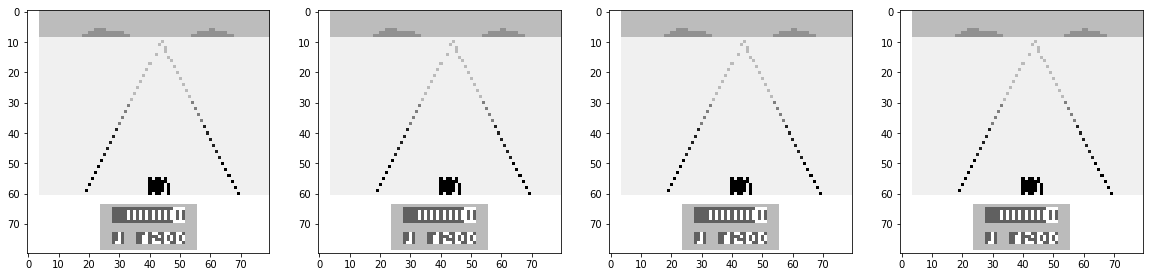

In [5]:
fig = plt.figure(figsize = (20,8))
ax = fig.add_subplot(141)
ax.imshow(state[0], cmap='Greys')

ax = fig.add_subplot(142)
ax.imshow(state[0], cmap='Greys')

ax = fig.add_subplot(143)
ax.imshow(state[0], cmap='Greys')

ax = fig.add_subplot(144)
ax.imshow(state[0], cmap='Greys')

plt.show()

In [6]:
NUM_FRAMES = 4
agent = DQNAgent(DuelingNet, NUM_FRAMES, a_dim, lr = 1e-3, batch_size = 32)

In [7]:
NUM_EPISODES = 300
PRINT_EVERY = 30
TMAX = 400

eps_start = 1.0
eps_end = 0.01
eps_decay = 0.95

score_list = []
score_window = deque(maxlen = 50)
best_score = 10.0

eps = eps_start

In [8]:
for e in range(1, NUM_EPISODES+1):
    score = 0
    env.reset()
    frame_list = []
    for _ in range(NUM_FRAMES):
        frame, reward, done, _ = env.step(0)
        frame_list.append(frame)
        score += reward
    state = preprocess_frames(frame_list)
    for t in range(TMAX):
        action = agent.get_action(state, eps)
        next_state, reward, done = act(env, action, k = NUM_FRAMES)
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if done:
            break
            
    eps = max(eps_end, eps_decay * eps)
    agent.scheduler.step()
    
    score_window.append(score)
    mean_score = np.mean(score_window)
    score_list.append([score, mean_score])
    
    print('\rEpisode {}\t score {:8.2f}\t mean score {:8.2f}'.format(e, score, mean_score), end = "")
    if e % PRINT_EVERY == 0:
        print('\rEpisode {}\t score {:8.2f}\t mean score {:8.2f}'.format(e, score, mean_score))
            
    if score >= best_score:
        print('\rEpisode {}\t score {:8.2f}\t mean score {:8.2f}\t saved!'.format(e, score, mean_score))
        torch.save(agent.online_net.state_dict(), 'checkpoint.pth')
        best_score = score

NameError: name 'preprocess_frames' is not defined

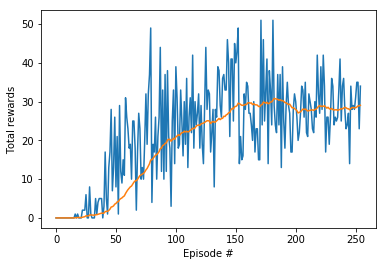

In [9]:
fig = plt.figure()
plt.plot(np.arange(len(score_list)), score_list)
plt.ylabel('Total rewards')
plt.xlabel('Episode #')
plt.savefig('plot_of_rewards.png')
plt.show()

In [14]:
agent.online_net.load_state_dict(torch.load('checkpoint.pth'))

In [12]:
torch.save(agent.online_net.cpu().state_dict(), 'enduro_0.pth')

# 3. Watch a trained agent

In [16]:
import sys
sys.path.append('../')

import gym

from agent import *
from model import *

from gym.wrappers import Monitor
def wrap_env(env):
    env = Monitor(env, '../video', force=True)
    return env

In [17]:
#env = gym.make('Enduro-v0')
#env = gym.make('EnduroDeterministic-v4')
env = wrap_env( gym.make('EnduroDeterministic-v4'))
print(env.observation_space)
print(env.action_space)

a_dim = env.action_space.n

Box(210, 160, 3)
Discrete(9)


In [18]:
NUM_FRAMES = 4
agent = DQNAgent(DuelingNet, NUM_FRAMES, a_dim)
agent.online_net.load_state_dict(torch.load('../model_weights/enduro_0.pth'))

<All keys matched successfully>

In [19]:
# load checkpoint parameters
agent.online_net.eval()
NUM_EPISODES = 3
for e in range(1, NUM_EPISODES+1):
    score = 0
    env.reset()
    frame_list = deque(maxlen = NUM_FRAMES)
    for _ in range(NUM_FRAMES):
        frame, reward, done, _ = env.step(0)
        frame_list.append(frame)
        score += reward
    state = preprocess_frames(frame_list)
    while True:
        action = agent.get_action(state, 0)
        next_state, reward, done = act(env, action, k = NUM_FRAMES)
        state = next_state
        score += reward
        if done:
            break
        
    print('Episode {}...sum of rewards {}'.format(e, score))

Episode 1...sum of rewards 66.0
Episode 2...sum of rewards 66.0
Episode 3...sum of rewards 66.0


In [ ]:
# close the environment
env.close()